<a href="https://colab.research.google.com/github/mdaugherity/MachineLearning2024/blob/main/tutorial/Tutorial_06_Tuning_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dr. Daugherity, PHYS 453

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Tutorial 6 - Tuning and Evaluation


We've already discussed some binary classification metrics in class and have played with evaluating mystery classifiers using the built-in reports:
* User's Guide: https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics
* Classification Report: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report

Now we make this approach more official and see how to properly tune and evaluate classifiers.  Remember, the goal is to finish the overview of classification problems before we dive in to seeing how more classifiers actually work.



# Test/Train Split
To meet our goal of making the "best" classifier we have to answer two closely related questions:
1.  How do we choose the best parameters to avoid under/over-fitting?
1.  How well will our classifier do with *new* samples?  

The answer to both is to split the dataset and save a fraction as our "test" data that we **DO NOT FIT THE CLASSIFIER** with.  

<img src='https://scikit-learn.org/stable/_images/grid_search_workflow.png' width=500>

The concept of saving data where we know the right answer is our key to tuning parameters and estimating performance.  Data that has been used to train the classifier **cannot** be use to fairly evaluate a classifier.

We will do this twice:
* Data used for tuning the best parameters is usually called **VALIDATION DATA**.  We will use a cool trick called cross-validation to use all of the data efficiently.
* After all of the choices are made and everything is done, only then will we use the **TEST DATA** to estimate the final performance of the classifier on new data.

**References**
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
* https://scikit-learn.org/stable/modules/cross_validation.html  (figure source)
* https://scikit-learn.org/stable/common_pitfalls.html#data-leakage


## Random State
Before we begin, it is important to understand how ```random_state``` works.  In a nutshell, there is no such thing as a random number in computing.  All random numbers are generated from a seed, and the same algorithm with the same seed produces the same list of numbers.  It is sometimes convenient to get set the seed with ```random_state``` to get the same results while you are working.  Common values are 0,1, 42, or other sci-fi / pop-culture references.  

A good analogy is to think about a book filled with numbers.  Setting random_state tells the program which page of the book to use.  

For more detail, read section 10.3 in https://scikit-learn.org/stable/common_pitfalls.html

In [2]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

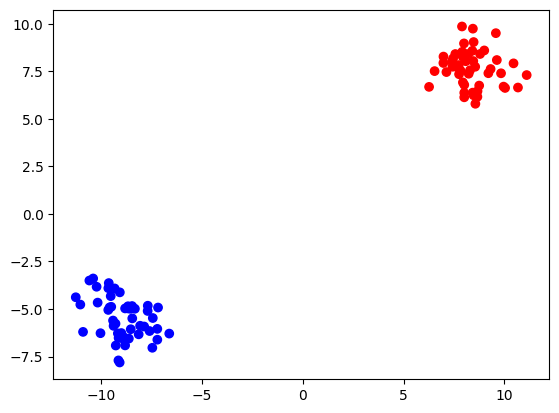

In [3]:
# Run this with and without random_state
#X,y = make_blobs(centers=2, random_state=0)
X,y = make_blobs(centers=2)

plt.scatter(X[:,0], X[:,1],c=y,cmap='bwr')
plt.show()

(100,) (75,) (25,)


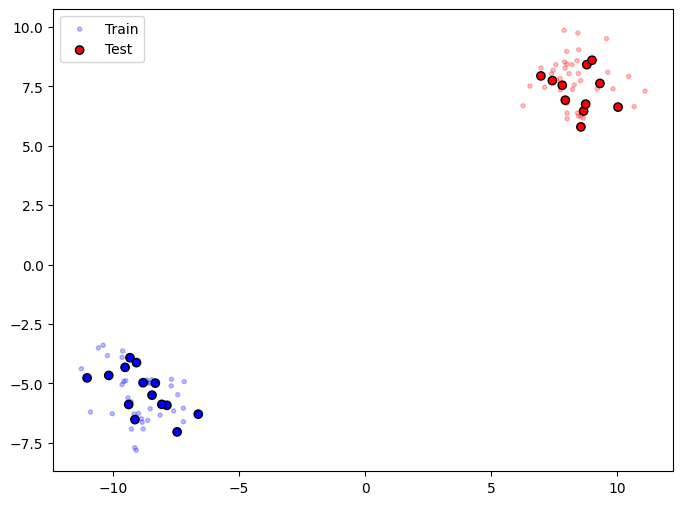

In [4]:
# Run this with and without random_state
#X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(y.shape, y_train.shape, y_test.shape)

plt.figure(figsize=(8,6))
plt.scatter(X_train[:,0], X_train[:,1],marker='.',c=y_train,cmap='bwr',label='Train', alpha=0.25)
plt.scatter(X_test[:,0], X_test[:,1],marker='o',edgecolor='k',c=y_test,cmap='bwr',label='Test')
plt.legend()

plt.show()

# Choosing the right values (tuning parameters)
Essentially all classifiers have parameters you can tune to improve performance.  For example, how do we choose k for kNearestNeighbors?

In [5]:
from sklearn import datasets
from sklearn import neighbors
from sklearn import model_selection

In [6]:
clf = neighbors.KNeighborsClassifier(n_neighbors=5)   # how many to pick?

In [7]:
#data = datasets.load_iris()
data = datasets.load_breast_cancer()
print('Features:\t',data.feature_names)
print('Targets:\t',data.target_names)

X = data.data
y = data.target
print(X.shape)

Features:	 ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Targets:	 ['malignant' 'benign']
(569, 30)


# HARD MODE: Manual Brute Force
We'll start by doing things the hard way for transparency.  The basic approach is:
1.  Split the data into testing and training sets
1.  Further split a validation set from the training set (be careful with ratios!)
1.  Call ```fit``` on training data
1.  Score the classifier on the validation data
1.  Use brutal force to try lots of options and pick the best validation score
1.  Refit the classifier on the all of training data (incluing validation set) with the best parameters

Play with this code below.  Notice how the results depend on test_size and can be VERY sensitive on random_state.


(569, 30)
Best k: 14
Best Test Score: 0.930


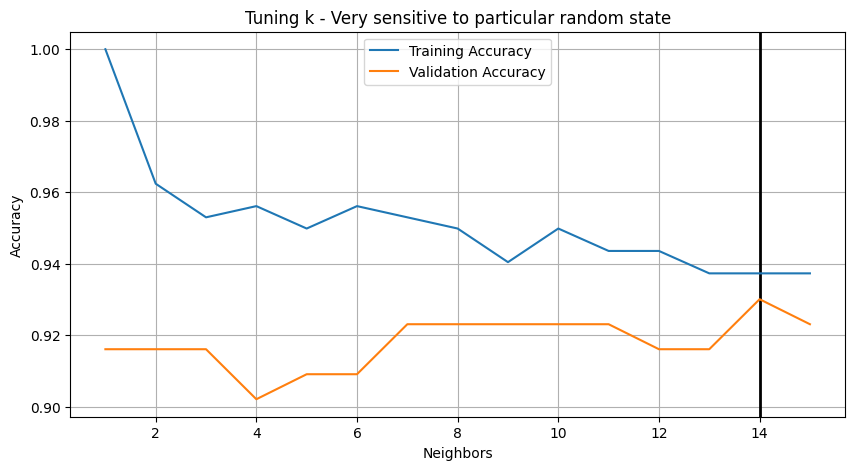

In [8]:
# Run this with and without random_state
X_trainall, X_test, y_trainall, y_test = model_selection.train_test_split(X, y) #random_state=1)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_trainall, y_trainall) #random_state=1)
print(X.shape)

KLIST = np.arange(1,16)

# DOING THIS THE HARD WAY--don't use this method
# Manually check lots of values of k to find the best test score
train_scores = np.zeros_like(KLIST,dtype=float)  # don't want INTs here!
val_scores =  np.zeros_like(KLIST,dtype=float)
for i,k in enumerate(KLIST):
  clf = neighbors.KNeighborsClassifier(n_neighbors=k)
  clf.fit(X_train,y_train)
  val_scores[i] = clf.score(X_test,y_test)
  train_scores[i] = clf.score(X_train,y_train)

best_k = KLIST[val_scores.argmax()]
print(f"Best k: {best_k}")
print(f"Best Test Score: {val_scores.max():0.3f}")
clf = neighbors.KNeighborsClassifier(n_neighbors=best_k)
clf.fit(X_trainall,y_trainall) # refit with best parameter

plt.figure(figsize=(10,5))
plt.axvline(best_k, color='black', lw=2) # draw black line behind best params
plt.plot(KLIST, train_scores, label='Training Accuracy')
plt.plot(KLIST, val_scores, label='Validation Accuracy')
plt.legend()
plt.xlabel('Neighbors')
plt.ylabel('Accuracy')
plt.title('Tuning k - Very sensitive to particular random state')
plt.grid()
plt.show()

# EASY MODE: Cross Valildation Grid Search

A great way to get more consistent results is to use **cross validation**.  
First we hide away some **test data**.  Then we divide the remainder into the **training** and **validation** sets.  We pick a value for the parameters, fit it with training data and score it on validation data.  We do the process 5 times cycling through different validation sets and average over the results to ensure that the entire training data set gets used.

As always, we DO NOT PEEK at the test data until we have completely finalized our classifier.

<img src='https://scikit-learn.org/stable/_images/grid_search_cross_validation.png' width=500>

In this example below, we'll see how cross validation gives more stable results than the previous example.

**References:**
* https://scikit-learn.org/stable/modules/cross_validation.html#multimetric-cross-validation
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV





In [9]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)  #random_state=1)

# Automatically search for the best parameters
KLIST = np.arange(1,16)
WLIST = ['uniform','distance']
params = {'n_neighbors':KLIST, 'weights':WLIST}  # Set up parameters to try
print('Parameters to try:',params)

grid_clf = model_selection.GridSearchCV(neighbors.KNeighborsClassifier(), param_grid=params, return_train_score=True)
grid_clf.fit(X,y)

print('Best estimator:', grid_clf.best_estimator_)
print('Best parameters:', grid_clf.best_params_)
print('Best score:', grid_clf.best_score_)

Parameters to try: {'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), 'weights': ['uniform', 'distance']}
Best estimator: KNeighborsClassifier(n_neighbors=13)
Best parameters: {'n_neighbors': 13, 'weights': 'uniform'}
Best score: 0.9332401800962584


## Using the Winner
By default (you can control this with the ```refit``` option) the grid search checks the cross-validation score, picks the best one (lowest index in case of ties), then refits using those parameters to the entire training set.  

Then, every time you use the classifier it **automatically** uses this winner.

In [10]:
grid_clf.predict(X_test) # automatically uses the refitted winner!

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0])

In [11]:
grid_clf.score(X_test, y_test)

0.9736842105263158

## Diving In
The above example shows how quick and easy it is to get a result using GridSearchCV.  Below are totally unnecesary examples of how to dive in to the search results and see what happened.

In [12]:
res = grid_clf.cv_results_
res.keys() # Wow, look at all of this

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_n_neighbors', 'param_weights', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [13]:
res

{'mean_fit_time': array([0.00069623, 0.00347095, 0.00066538, 0.00160508, 0.00236402,
        0.00054879, 0.00059657, 0.0006557 , 0.00061469, 0.0005456 ,
        0.00105934, 0.00046077, 0.00069156, 0.00100508, 0.00062356,
        0.0006259 , 0.00135479, 0.00161142, 0.00064793, 0.00052905,
        0.00062933, 0.00051103, 0.00062637, 0.00055904, 0.00065899,
        0.00203462, 0.00470023, 0.00056682, 0.00049815, 0.00041981]),
 'std_fit_time': array([6.21250197e-05, 3.59353053e-03, 6.58724949e-05, 2.05771413e-03,
        3.48530415e-03, 1.09188879e-04, 7.06992740e-05, 1.17807095e-04,
        1.03484144e-04, 5.26939797e-05, 8.95861006e-04, 1.08083176e-04,
        1.87138180e-04, 8.30522619e-04, 4.86651042e-05, 7.22925706e-05,
        1.35207445e-03, 1.31355627e-03, 7.36614795e-05, 9.14814294e-05,
        3.22098471e-05, 7.03184629e-05, 1.03388303e-04, 5.50120894e-05,
        1.72045860e-04, 2.84180095e-03, 8.10226609e-03, 8.68857755e-05,
        6.59299755e-05, 2.03097927e-05]),
 'mean_scor

In [14]:
# Make a lovely table:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html#sphx-glr-auto-examples-model-selection-plot-grid-search-stats-py
import pandas as pd
results_df = pd.DataFrame(grid_clf.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")

results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]].head(10)  # only show best options

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
13_uniform,"{'n_neighbors': 13, 'weights': 'uniform'}",1,0.933240,0.028568
12_uniform,"{'n_neighbors': 12, 'weights': 'uniform'}",2,0.933225,0.024539
9_distance,"{'n_neighbors': 9, 'weights': 'distance'}",3,0.931486,0.032017
10_uniform,"{'n_neighbors': 10, 'weights': 'uniform'}",4,0.931470,0.027934
9_uniform,"{'n_neighbors': 9, 'weights': 'uniform'}",4,0.931470,0.027934
15_uniform,"{'n_neighbors': 15, 'weights': 'uniform'}",6,0.929731,0.031332
15_distance,"{'n_neighbors': 15, 'weights': 'distance'}",7,0.929716,0.031354
14_uniform,"{'n_neighbors': 14, 'weights': 'uniform'}",7,0.929716,0.027145
13_distance,"{'n_neighbors': 13, 'weights': 'distance'}",7,0.929716,0.031354


## Helper Functions
Here's some for visualizing the output of a grid search.  Be warned that this only works for 2 parameters.

In [15]:
#https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv with a fixed bug

def plot_2par_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2,show_train=1):
  """Plot GridCV results for two parameter searches"""
  # Get Test Scores Mean and std for each grid search
  val_scores = np.array(cv_results['mean_test_score']).reshape(len(grid_param_1),len(grid_param_2)) # FIXED A BUG HERE
  train_scores = np.array(cv_results['mean_train_score']).reshape(len(grid_param_1),len(grid_param_2))

  _, ax = plt.subplots(1,1,figsize=(10,4))
  cmap = plt.get_cmap("tab10")

  # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
  for idx, val in enumerate(grid_param_2):
    ax.plot(grid_param_1, val_scores[:,idx], '-o',  color=cmap(idx), label=f"Validation: {name_param_2}={str(val)}") # FIXED
    if show_train: ax.plot(grid_param_1, train_scores[:,idx], ':.', color=cmap(idx), label=f"Train: {name_param_2}={str(val)}")

  ax.set_title("Grid Search Scores")
  ax.set_xlabel(name_param_1)
  ax.set_ylabel('CV Average Score')
  ax.legend()
  ax.grid('on')

## GridCV With Plots

Parameters to try: {'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), 'weights': ['uniform', 'distance']}
Best estimator: KNeighborsClassifier(n_neighbors=13)
Best parameters: {'n_neighbors': 13, 'weights': 'uniform'}
Best score: 0.9332401800962584


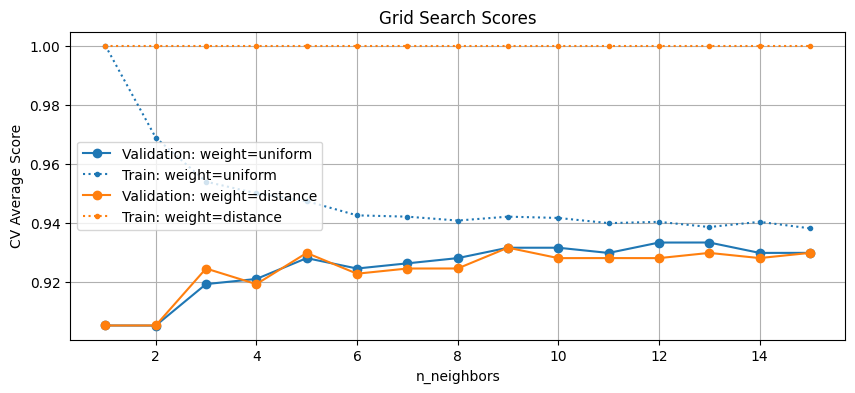

In [16]:
# Try this with and without random_state
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)  #random_state=1)

# Automatically search for the best parameters
KLIST = np.arange(1,16)
WLIST = ['uniform','distance']
params = {'n_neighbors':KLIST, 'weights':WLIST}  # Set up parameters to try
print('Parameters to try:',params)

grid_clf = model_selection.GridSearchCV(neighbors.KNeighborsClassifier(), param_grid=params, return_train_score=True)
grid_clf.fit(X,y)

print('Best estimator:', grid_clf.best_estimator_)
print('Best parameters:', grid_clf.best_params_)
print('Best score:', grid_clf.best_score_)

plot_2par_grid_search(grid_clf.cv_results_, KLIST, WLIST, 'n_neighbors', 'weight')

In [17]:
# Check the numbers
for i in range(0,30,2):
  print(f"{res['params'][i]}\t{res['mean_test_score'][i]:0.3f}")
print()
for i in range(1,30,2):
  print(f"{res['params'][i]}\t{res['mean_test_score'][i]:0.3f}")

{'n_neighbors': 1, 'weights': 'uniform'}	0.905
{'n_neighbors': 2, 'weights': 'uniform'}	0.905
{'n_neighbors': 3, 'weights': 'uniform'}	0.919
{'n_neighbors': 4, 'weights': 'uniform'}	0.921
{'n_neighbors': 5, 'weights': 'uniform'}	0.928
{'n_neighbors': 6, 'weights': 'uniform'}	0.924
{'n_neighbors': 7, 'weights': 'uniform'}	0.926
{'n_neighbors': 8, 'weights': 'uniform'}	0.928
{'n_neighbors': 9, 'weights': 'uniform'}	0.931
{'n_neighbors': 10, 'weights': 'uniform'}	0.931
{'n_neighbors': 11, 'weights': 'uniform'}	0.930
{'n_neighbors': 12, 'weights': 'uniform'}	0.933
{'n_neighbors': 13, 'weights': 'uniform'}	0.933
{'n_neighbors': 14, 'weights': 'uniform'}	0.930
{'n_neighbors': 15, 'weights': 'uniform'}	0.930

{'n_neighbors': 1, 'weights': 'distance'}	0.905
{'n_neighbors': 2, 'weights': 'distance'}	0.905
{'n_neighbors': 3, 'weights': 'distance'}	0.924
{'n_neighbors': 4, 'weights': 'distance'}	0.919
{'n_neighbors': 5, 'weights': 'distance'}	0.930
{'n_neighbors': 6, 'weights': 'distance'}	0.923


# Conclusion
* Use a test/train split to evaulate your classifier.  
* Do a CV Grid Search on the training data to tune parameters